In [1]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import scipy as sp
from scipy import interpolate
from matplotlib import pyplot as plt

In [2]:
class SpectraDataset(Dataset):
    def __init__(self, index_list,path = "/home/drors/project/sampled/target data"):
        self.tables = {}
        self.standard = {}
        os.chdir(path)
        self.index_list = index_list
        root = os.getcwd()
        for file_name in os.listdir():
            file_path = os.path.join(root,file_name)
            file_read = pd.read_csv(file_path)
            file_name_split = file_name.split('_')
            index = int(file_name_split[0])
            if index in index_list:
                if file_name_split[2] == 'ts':
                    file_type = file_name_split[1] + " " + file_name_split[2]
                    column_list = [column for column in file_read.columns if "s_" in column]
                    file_read = file_read.dropna(subset = column_list)
                else:
                    file_type = file_name_split[2]
                if index in self.tables:
                    self.tables[index][file_type] = file_read
                else:
                    self.tables[index] = {file_type : file_read}
        to_remove = [] #cant change the dictionary while iterating over it
        for index in self.tables:
            if len(self.tables[index]) < 3 and index_list != [1]:
                to_remove.append(index)
        for index in to_remove:
            self.tables.pop(index)
            self.index_list.remove(index)
        self.get_standard_vector()
        #self.normalize_vectors()
        
    def get_standard_vector(self):
        min_source = -1000000
        min_target = -1000000
        max_source = 1000000 
        max_target = 1000000
        length_source = 1000000
        length_target = 1000000
        for index in self.tables:
            columns = [column for column in self.tables[index]['0 ts'].columns if "w_" in column]
            mins_source = self.tables[index]['0 ts'][columns].min().max()
            maxs_source = self.tables[index]['0 ts'][columns].max().min()
            sources_length = len(self.tables[index]['0 ts'][columns].index)
            columns = [column for column in self.tables[index]['ORIG ts'].columns if "w_" in column]
            mins_target = self.tables[index]['ORIG ts'][columns].min().max()
            maxs_target = self.tables[index]['ORIG ts'][columns].max().min()
            targets_length = len(self.tables[index]['ORIG ts'][columns].index)

            if mins_source > min_source:
                min_source = mins_source
            if mins_target > min_target:
                min_target = mins_target
            if max_source > maxs_source:
                max_source = maxs_source
            if max_target > maxs_target:
                max_target = maxs_target
            if length_source > sources_length:
                length_source = sources_length
            if length_target > targets_length:
                length_target = targets_length
        self.standard["min source"] = min_source
        self.standard["max source"] = max_source
        self.standard["min target"] = min_target
        self.standard["max target"] = max_target
        self.standard["source len"] = length_source
        self.standard["target len"] = length_target
    
    def normalize_vectors(self):
        self.data = {}
        for index in self.tables:
            self.data[index] = {}
            columns_w = [column for column in self.tables[index]['0 ts'].columns if "w_" in column]
            columns_s = [column for column in self.tables[index]['0 ts'].columns if "s_" in column]
            self.data[index]['source'] = np.zeros((20,self.standard["source len"]))
            for i,(w,s)  in enumerate(zip(columns_w,columns_s)):
                    
                x = self.tables[index]['0 ts'][w].to_numpy()
                y = self.tables[index]['0 ts'][s].to_numpy()
                z = interpolate.interp1d(x, y, kind='quadratic',fill_value="extrapolate")
                self.data[index]['source'][i,:] = z(self.standard["vector source"])
            columns_w = [column for column in self.tables[index]['ORIG ts'].columns if "w_" in column]
            columns_s = [column for column in self.tables[index]['ORIG ts'].columns if "s_" in column]
            self.data[index]['target'] = np.zeros((2,self.standard["target len"]))
            for i,(w,s)  in enumerate(zip(columns_w,columns_s)):
                x = self.tables[index]['ORIG ts'][w].to_numpy()
                y = self.tables[index]['ORIG ts'][s].to_numpy()
                z = interpolate.interp1d(x, y, kind='quadratic', fill_value="extrapolate")
                self.data[index]['target'][i,:] = z(self.standard["vector target"])
    def __len__(self):
        return len(self.index_list) * 20
    def __getitem__(self,idx):
        #idx = idx + 20
        table_idx = idx // 20
        table_idx = self.index_list[table_idx]
        #x = self.tables[table_idx]['0 ts']
        #x = x[f's_{idx % 20}']
        x = self.data[table_idx]['source'][idx % 20,:]
        #y = self.tables[table_idx]['ORIG ts']
        #y = y[['s_0','s_1']]
        y = self.data[table_idx]['target']
        return idx,x,y
    
    def getTimeVector(self,table_idx):
        base = self.tables[table_idx]['vrad']
        #column_list = [f'time_{i}' for i in range(20)]
        #print(base[column_list])
        return base.iloc[2,1:].to_numpy(dtype = np.float64)
    def getSpeedMatrix(self, table_idx):
        base = self.tables[table_idx]['vrad']
        return base.iloc[0:2,1:].to_numpy()
    def additive_collate(self,batch):
        table_idx = batch[0][0] // 20
        table_idx = self.index_list[table_idx]
        times = self.getTimeVector(table_idx)
        readings = np.asarray([row[1] for row in batch])
        real = batch[1][2]
        speeds = self.getSpeedMatrix(table_idx)
        return torch.from_numpy(readings),torch.from_numpy(real),table_idx,torch.from_numpy(times), torch.from_numpy(speeds)
    def set_standard(self,values):
        self.standard["min source"] = values["min source"]
        self.standard["max source"] = values["max source"]
        self.standard["min target"] = values["min target"]
        self.standard["max target"] = values["max target"]
        self.standard["vector source"] = values["vector source"]
        self.standard["vector target"] = values["vector target"]
        self.standard["source len"] = values["source len"]
        self.standard["target len"] = values["target len"]

In [3]:
def getLoader(seed = None):
    if seed != 0:
        np.random.seed(seed)
    perm = np.random.permutation(np.arange(1,121))
    train = perm[0:90].tolist()
    test = perm[90:105].tolist()
    val = perm[105:121].tolist()
    train_set = SpectraDataset(train)
    test_set = SpectraDataset(test)
    val_set = SpectraDataset(val)
    standard_values = {}
    standard_values["min source"] = max(train_set.standard["min source"],val_set.standard["min source"],test_set.standard["min source"])
    standard_values["max source"] = min(train_set.standard["max source"],val_set.standard["max source"],test_set.standard["max source"])
    standard_values["min target"] = max(train_set.standard["min target"],val_set.standard["min target"],test_set.standard["min target"])
    standard_values["max target"] = min(train_set.standard["max target"],val_set.standard["max target"],test_set.standard["max target"])
    standard_values["source len"] = min(train_set.standard["source len"],val_set.standard["source len"],test_set.standard["source len"])
    standard_values["target len"] = min(train_set.standard["target len"],val_set.standard["target len"],test_set.standard["target len"])
    standard_values["source len"] = (standard_values["source len"] // 100) * 100
    standard_values["target len"] = (standard_values["target len"] // 100) * 100
    standard_values["vector source"] = np.linspace(standard_values["min source"],standard_values["max source"], num = standard_values["source len"])
    standard_values["vector target"] = np.linspace(standard_values["min target"],standard_values["max target"], num = standard_values["target len"])
    
    train_set.set_standard(standard_values)
    test_set.set_standard(standard_values)
    val_set.set_standard(standard_values)
    
    
    train_set.normalize_vectors()
    test_set.normalize_vectors()
    val_set.normalize_vectors()
    
    train_loader = DataLoader(train_set, batch_size = 20, collate_fn = train_set.additive_collate)
    test_loader = DataLoader(test_set, batch_size = 20, collate_fn = test_set.additive_collate)
    val_loader = DataLoader(val_set, batch_size = 20, collate_fn = val_set.additive_collate)
    return train_loader, test_loader, val_loader, standard_values

torch.Size([20, 7500])
torch.Size([2, 1700])
13
torch.Size([20])
torch.Size([2, 20])
torch.Size([20, 7500])
torch.Size([2, 1700])
68
torch.Size([20])
torch.Size([2, 20])
torch.Size([20, 7500])
torch.Size([2, 1700])
41
torch.Size([20])
torch.Size([2, 20])
{'min source': 4992.544013409346, 'max source': 5087.104146943163, 'min target': 4990.122000000003, 'max target': 5079.972000001964, 'source len': 7500, 'target len': 1700, 'vector source': array([4992.54401341, 4992.55662311, 4992.56923281, ..., 5087.07892754,
       5087.09153724, 5087.10414694]), 'vector target': array([4990.122     , 4990.17488405, 4990.2277681 , ..., 5079.8662319 ,
       5079.91911595, 5079.972     ])}


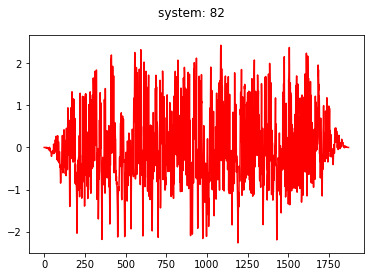

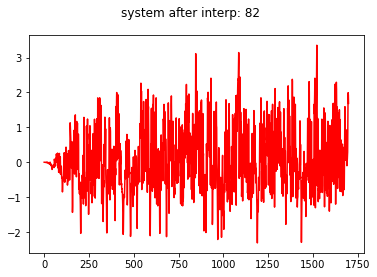

In [22]:
dataloader = getLoader()
iterator = iter(dataloader[0])
test = next(iterator)
for item in test:
    if type(item) is int:
        print(item)
    else:
        print(item.shape)
iterator = iter(dataloader[1])
test = next(iterator)
for item in test:
    if type(item) is int:
        print(item)
    else:
        print(item.shape)

iterator = iter(dataloader[2])
test = next(iterator)
for item in test:
    if type(item) is int:
        print(item)
    else:
        print(item.shape)
print(dataloader[3])

In [ ]:
dataset = SpectraDataset()
for i, batch in enumerate(dataset):
    if i > 40:
        break;
    else:
        print(i,batch)

# Normalizing the input vectors

in order to normalize the vectors to some sample wave length (we will try to take the most common wave lengths of the vectors, with the minimal length of them)

## The Steps are:
### 1. find the minimal length of all the ground-truth vectors
### 2. find the maximal lower-bound of the wave-length values 
(the biggest value the waves start from - the smllest in the vector)
### 3. find the minimal upper-bound of the wave-length values  
(the smallest value the waves end at - the biggest in the vector)
### 4. create the range of new waves in an equally spaced wave lengths vector
(2.value <-> 3.value, with 1.value amounts)

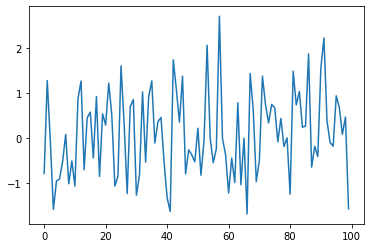

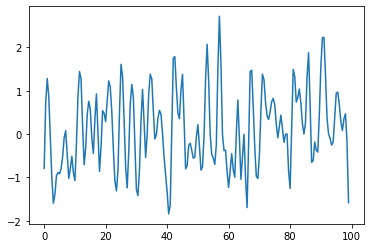

In [32]:
x = np.array(range(0, 100))
y = np.random.randn(len(x))
z = interpolate.interp1d(x, y, kind='quadratic')
std = np.array(range(0,199))/2
# print(std)
z_std = z(std)
pyplot.plot(x,y)
pyplot.figure()
pyplot.plot(std,z_std)

In [1]:
def rename_col(base):
    if "wv" in base:
        return base.replace('v','')
    else:
        return base.replace('p','')

In [24]:
path_orig = "/home/drors/project/real data"
path_target = "/home/drors/project/real data sampled"

for filename in os.listdir(path_orig):
    if "data" in filename:
        full_path = os.path.join(path_orig, filename)
        data = pd.read_csv(full_path)
        data = data.iloc[::5]
        data = data.rename(rename_col, axis = 'columns')
        print(len(data.columns))
        print(data.columns)
        if len(data.columns) > 41:
            data = data.iloc[:,:41]
        print(data.columns)
        path_to_write = os.path.join(path_target,filename)
        data.to_csv(path_to_write, index = False)

43
Index(['Unnamed: 0', 'w_0', 's_0', 'w_1', 's_1', 'w_2', 's_2', 'w_3', 's_3',
       'w_4', 's_4', 'w_5', 's_5', 'w_6', 's_6', 'w_7', 's_7', 'w_8', 's_8',
       'w_9', 's_9', 'w_10', 's_10', 'w_11', 's_11', 'w_12', 's_12', 'w_13',
       's_13', 'w_14', 's_14', 'w_15', 's_15', 'w_16', 's_16', 'w_17', 's_17',
       'w_18', 's_18', 'w_19', 's_19', 'w_20', 's_20'],
      dtype='object')
Index(['Unnamed: 0', 'w_0', 's_0', 'w_1', 's_1', 'w_2', 's_2', 'w_3', 's_3',
       'w_4', 's_4', 'w_5', 's_5', 'w_6', 's_6', 'w_7', 's_7', 'w_8', 's_8',
       'w_9', 's_9', 'w_10', 's_10', 'w_11', 's_11', 'w_12', 's_12', 'w_13',
       's_13', 'w_14', 's_14', 'w_15', 's_15', 'w_16', 's_16', 'w_17', 's_17',
       'w_18', 's_18', 'w_19', 's_19'],
      dtype='object')
5
Index(['Unnamed: 0', 'w_1', 's_1', 'w_2', 's_2'], dtype='object')
Index(['Unnamed: 0', 'w_1', 's_1', 'w_2', 's_2'], dtype='object')


In [9]:
def get_real_loader(std_vector):
    dataset = SpectraDataset(index_list = [1], path = "/home/drors/project/real data sampled")
    x = torch.zeros((20,std_vector['source len']))
    y = torch.zeros((2,std_vector['target len']))
    dataset.set_standard(std_vector)
    dataset.normalize_vectors()
    for i,(_,source,target) in enumerate(dataset):
        x[i,:] = torch.from_numpy(source)
        y = torch.from_numpy(target)
    return x,y

In [8]:
dataloader = getLoader()
print(get_real_loader(dataloader[3])[1].shape)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [10]:
print(get_real_loader(dataloader[3])[0].shape)

torch.Size([20, 7500])


In [11]:
print(get_real_loader(dataloader[3])[1].shape)

torch.Size([2, 1700])


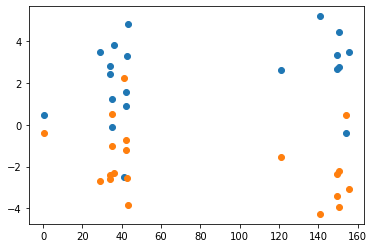

In [2]:
ttt = [0.5258358498103917,311.78148982999846,341.84771745977923,433.56606571003795,1087.7946868599392,1087.6849441300146,1088.5976183298044,1088.6789588402025,1128.6752032698132,1128.5791229400784,1129.6505303801969,1129.5734185199253,1130.54320129985,1135.6618717098609,1136.5898129399866,1136.6504905801266,1137.620776989963,1137.5821229401045,1548.5132086100057,1561.4949623998255,1563.4780927198008]

plt.scatter([t % 156.38 for t in ttt[:-1]], [ 0.4807,  3.4946,  3.4890,  2.6325,  3.3601,  2.6683,  2.7920,  4.4577,
          2.4410,  2.8286, -0.1037,  1.2503,  3.8465, -2.4791,  1.5586,  0.8806,
          4.8355,  3.2758,  5.2041, -0.3927], )
plt.scatter([t % 156.38 for t in ttt[:-1]], [-0.3747, -3.0976, -2.6736, -1.5612, -3.4014, -2.3724, -2.1985, -3.9267,
         -2.5787, -2.4000,  0.5146, -1.0211, -2.3276,  2.2298, -1.1851, -0.7104,
         -3.8605, -2.5371, -4.2727,  0.4841], )